# Karis Gwet - DBSCAN

# 1. Generate a random cluster dataset

In [501]:
from sklearn.datasets import make_blobs

In [502]:
X, y = make_blobs(n_samples=750, centers=3, cluster_std=0.4, n_features=2,random_state=0)

# 2. Visualize the data

In [503]:
import matplotlib.pyplot as plt

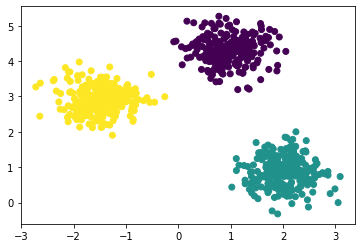

In [504]:
plt.scatter(X[:,0], X[:,1], c=y);

# 3. Create functions from scratch that allow you to call DBSCAN on a dataset

Dans un premier temps, on va prendre aléatoirement des "Core Points". 

Un Core Point est un point qui enveloppe plusieurs autres points (càd le nombre de points qui sont proches du point aléatoirement choisi). Le nombre de points enveloppé est choisi arbitrairement selon le problème que l'on rencontre.

Le premier core point choisi aléatoirement fera parti de notre premier cluster. Tous les autres points qui sont proches du Core Point feront aussi parti du premier cluster. Tous les Core Points qui sont proches du premier cluster sont ajoutés au premier cluster.

Tous les Non Core Points qui sont proches du 1er cluster, seront ajoutés au premier cluster.

Le but de notre fonction core_point va être de vérifier si le point donné est un core point, un noise, ou un border. 

In [64]:
import pandas as pd
import numpy as np
import random

In [45]:
df = pd.DataFrame(X, columns = ["coord_x", "coord_y"])

In [46]:
df

,coord_x,coord_y
0,2.364345,0.233024
1,0.923118,4.184671
2,1.642210,0.722964
3,1.975908,0.935341
4,-1.687527,2.730492
...,...,...
745,2.246027,0.957043
746,1.047241,4.143075
747,1.841564,4.838399
748,2.168979,1.594731


Text(0.5, 1.0, 'Scattered data')

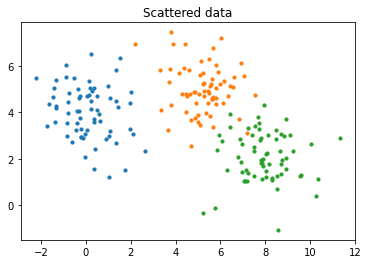

In [492]:
centers = [(0, 4), (5, 5) , (8,2)]
cluster_std = [1.2, 1, 1.1]

X, y= make_blobs(n_samples=200, cluster_std=cluster_std, centers=centers, n_features=2, random_state=1)

plt.scatter(X[y == 0, 0], X[y == 0, 1], s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], s=10, label="Cluster3")
plt.title("Scattered data")

Plus facile de traiter cela avec un dataframe

In [485]:
def what_is_the_point(eps, df, minimum_pts, idx):
    x_pt, y_pt = df.iloc[idx]['coord_x']  , df.iloc[idx]['coord_y']
    pts_index = []
    pts =  df[((np.abs(x_pt - df['coord_x']) <= eps) & (np.abs(y_pt - df['coord_y']) <= eps)) & (df.index != idx)]
    #points inside the circle

    if(len(pts) >= minimum_pts): #minimum numbers of points inside the circle
        #it's a core point
        pts_index = pts.index #all of our points in our circle
        core = True
        border = False
        noise = False
        return (pts.index, core, border, noise)
    elif(len(pts) > 0 and len(pts) < minimum_pts):
        #it's a border point (it has at least 1 point)
        #we will see in cluster_points how to put it in a cluster
        pts_index = pts.index 
        core = False
        border = True
        noise = False
        return (pts.index, core, border, noise)
    elif(len(pts) == 0):
        #it's a noise point (it doesn't have the minimum number of points)
        pts_index = pts.index 
        core = False
        border = False
        noise = True
        return (pts.index, core, border, noise)

In [486]:
def cluster_points(eps, df, minimum_pts):
    
    initial_cluster = 1
    clusters = []
    #curr_circle = []
    cur_pts = set()
    pts_idx = list(df.index) #all of my points
    #i = 0
    
    while(len(pts_idx) != 0): 
        frst_pt = True #first iteration
        cur_pts.add(random.choice(pts_idx))
    
        while(len(cur_pts) != 0):
            cur_pt = cur_pts.pop() #we choose a random point among all our points

            #now we have to know what is its nature
            pts_index, core, border, noise = what_is_the_point(eps, df, minimum_pts, cur_pt)
            if(border & frst_pt):
                #for first border point, we label it aand its neighbours as noise 
                clusters.append((cur_pt, 0))
                clusters.extend(list(zip(pts_index,[0 for _ in range(len(pts_index))])))
                
                #label as visited
                pts_idx.remove(cur_pt)
                pts_idx = [e for e in pts_idx if e not in pts_index]
    
                continue
            
            pts_idx.remove(cur_pt)
            neighbors_idx = set(pts_index) & set(pts_idx) #look at only unvisited points
            
            if(core): #it's a core
                frst_pt = False
                clusters.append((cur_pt,initial_cluster))
                cur_pts.update(neighbors_idx)
            elif(border): #it's a border but i can't not attribute a cluster for the moment
                clusters.append((cur_pt, initial_cluster))
                continue
            elif(noise): #if current point is noise
                clusters.append((cur_pt, 0))
                continue
                
        if not frst_pt:
            #increment cluster number
            initial_cluster = initial_cluster + 1
    #i = i + 1           
    return clusters

In [517]:
eps = 0.45
minimum_pts = 6

df = pd.DataFrame(X, columns = ["coord_x", "coord_y"])
clustered = cluster_points(eps, df, minimum_pts)

In [518]:
df

,coord_x,coord_y
0,2.364345,0.233024
1,0.923118,4.184671
2,1.642210,0.722964
3,1.975908,0.935341
4,-1.687527,2.730492
...,...,...
745,2.246027,0.957043
746,1.047241,4.143075
747,1.841564,4.838399
748,2.168979,1.594731


In [519]:
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])
cluster_df.idx

0      636
1      168
2       14
3      528
4      530
      ... 
745    177
746    181
747    184
748    188
749    376
Name: idx, Length: 750, dtype: int64

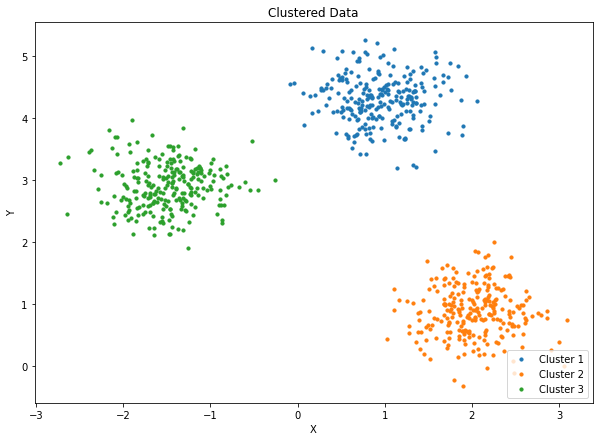

In [520]:
idx , cluster = list(zip(*clustered))
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])

plt.figure(figsize=(10,7))
for clust in np.unique(cluster):
    plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], s=10, label=f"Cluster{clust}")

plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.title('Clustered Data')
plt.xlabel('X');
plt.ylabel('Y');